# A computational approach to Swap Regression

### Problem Statement
A dataset where the observation points consist of 2(or more) parameters of which only one affects the output in a given range of input. To arrive at a general intuiton fot the concept we shall consider the exact problem discussed in the paper by Chow, that is the psychrometric chart given by pressure and temperature. Intuition tells us that regions in which pressure is the predictor we should regress on temperature and regions in which temperature is the predictors we regress on pressure. We represent the same using a Binary variable $Z$.

### Creating a Data-Set 
This is a dummy data set to test out the intuitive approaches that we develop to approximate SWAP regression. As illustrated in the paper it has two parameters temparature (on the x-axis) and Pressure (on the y-axis.)


In [603]:
# Importing Dependencies
import numpy as np
import matplotlib.pyplot as plt
from simpleRegression import generate_parameters

In [604]:
DATA = []
TEMP = []
PRESSURE = []
COLOR = []

# Entries where temperature is kept constant and Pressure is varied.
for temp in range(34,40):
    for pressure in np.arange(60-temp,70-temp,0.5):
        DATA.append((temp,pressure,1))
        TEMP.append(temp)
        PRESSURE.append(pressure)
        COLOR.append(1)
        
# Entries where temperature is kept constant and Pressure is varied.
for pressure in range(4,21):
    for temp in np.arange(48-pressure*0.5,54-pressure*0.5,0.5):
        DATA.append((temp,pressure,0))
        TEMP.append(temp)
        PRESSURE.append(pressure)
        COLOR.append(2)
        

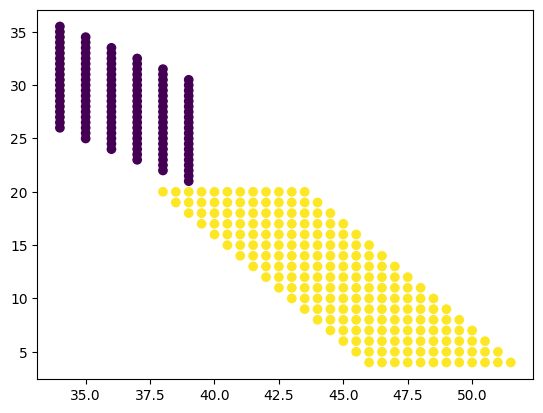

In [605]:
# Visualising the data 
plt.figure()
plt.scatter(
    TEMP,
    PRESSURE,
    c = COLOR,
)

##### Note:
This is a crude representation of the data given in the paper however, it has the feature that we are interested in namely the fact that the patter in the data depends on two different parameters over different regions.

In [606]:
# Converting the data into a matrix form and representing the same in a clean slate.
DATA = np.matrix(DATA)
DATA[:5]

matrix([[34. , 26. ,  1. ],
        [34. , 26.5,  1. ],
        [34. , 27. ,  1. ],
        [34. , 27.5,  1. ],
        [34. , 28. ,  1. ]])

##### Remark
An important fact to note in this data set is also the existence of the $Z$ parameter in the matrix (the indicator parameter as used in the paper) that assumes only two values 0 or 1. This is used to indicate whehter $X$ has to be regressed over $Y$ or vice-versa.

### Intution 

As stated before:
"When pressure is the predictor, we should regress temperature on pressure and when temperature is the predictor, we do the opposite."

So first we can observe the crude result of dividing the dataset into two parts according to the predictors and plot the regression lines on both of them.


In [607]:
a = DATA[0]
a[0]

matrix([[34., 26.,  1.]])

In [608]:
# Dividing the two data sets
Temp_pred_data_x = []
Temp_pred_data_y = []
for i in DATA:
    if i[0,2] == 1:
        Temp_pred_data_x.append(i[0,0])
        Temp_pred_data_y.append(i[0,1])
    
pressure_pred_data_x = []
pressure_pred_data_y = []
for i in DATA:
    if i[0,2] == 0:
        pressure_pred_data_x.append(i[0,0])
        pressure_pred_data_y.append(i[0,1])
    
# Regressing pressure over temperature 
params_temp = generate_parameters(
    Temp_pred_data_x,
    Temp_pred_data_y
)
# note the parameters are returned as (b0,b1)
# b0 - intercept
# b1 - slope

params_pressure = generate_parameters(
    pressure_pred_data_y,
    pressure_pred_data_x
)


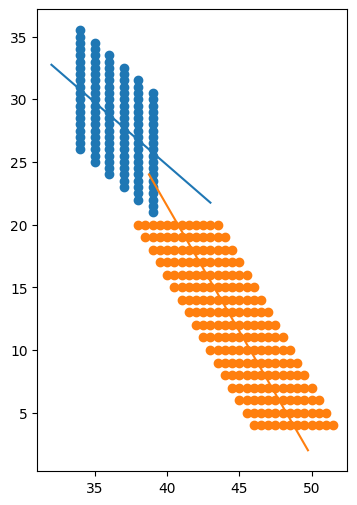

In [609]:
# Plotting the lines
plt.figure("Plots",
           figsize=(4,6)
           )
# Plotting the temp data
plt.scatter(
    Temp_pred_data_x,
    Temp_pred_data_y
)
# Plotting the temp regression line
b0, b1 = params_temp
Y_prime = []
for i in range(int(min(Temp_pred_data_x)-2),int(max(Temp_pred_data_x)+5)):
    Y_prime.append(b0 + b1*i)
plt.plot(range(int(min(Temp_pred_data_x)-2),int(max(Temp_pred_data_x)+5)), Y_prime)

# Plotting the pressure data
plt.scatter(
    pressure_pred_data_x,
    pressure_pred_data_y
)
# Plotting the pressure regression line
b0, b1 = params_pressure
X_prime = []
for i in range(int(min(pressure_pred_data_y)-2),int(max(pressure_pred_data_y)+5)):
    X_prime.append(b0 + b1*i)
plt.plot(X_prime, range(int(min(pressure_pred_data_y)-2),int(max(pressure_pred_data_y)+5)))

##### Remark 
Here we can clearly observe two different patterns that emerge out for the two diffrent markers and the end goal of the project is to develop a linear model such that we can classify the trend in the data using that one particular model.

### Approach
If we consider a matrix where the $X$ entries are column one, the $Y$ entries are column two and the indicator variable $Z$ is the third axis. We'd get a matrix that looks like this:

$$
A = \begin{pmatrix}
44 & 32 & 1\\
46 & 34 & 1\\
. & . & . \\ 
. & . & . \\ 
. & . & . \\ 
24 & 54 & 0\\
\end{pmatrix}
$$

When we look at our intuition mathematically, we want to regress $col_1$ on $col_2$ when $col_3$ is 1 and vice-versa when $col_3$ is 0.

### Recalling Regression
When we consider the simplistic model of :
$$
y = \beta X + \epsilon
$$
we know that the co-efficient matrix $\beta$ is calculated with the formula :
$$
\beta =({({X^T}X)}^{-1}  X)y
$$
Note: Assuming $X$ satisfies the Markov Theorem.

Hence, when we want to regress two columns of $A$ on each other based on the indicator variable $Z$ what we can consider is splitting the matrix based on $Z$.

### Method Discussed in the Paper

The idea in the paper is to consider an invertible function $f(x)$ such that :

$$E(Y|X,Z=0) = f(x)$$

and

$$E(X|Y,Z=1) = f^{-1}(x)$$

And to approximate such a function $f(x)$ we consider the set of functions :

$\mathscr{G}$ = {$g \in L^2(P_x)| g$ is an injection from $\Omega_x \rightarrow \Omega_y$ and $g^{-1} \in L^2(P_x)$ }

and we want to minimise the quadratic loss function :

$$Q = E[(Y- g(X))^2 I(Z = 0)] + E[(X- g(Y))^2 I(Z = 1)]$$

To approximate the loss function for our data set we can approximate $g_{\theta}$ to be :
$$g_{\theta}(x) = ax^2 + bx + c$$

Here, $\theta =  (a,b,c)^T$

clearly, 
$$g_{\theta}^{-1}(x) = {-b/2a + \sqrt{b^2 - 4a(c-y)}}/2a$$

Now, we simply need to minimise this approximator with respect to the quadratic loss function $Q$ discussed above:

$$Q_n(g_{\theta}) = E_n[(Y-aX^2 - bX- c)^2I(Z=0)] + E_n[X + ({b/2a + \sqrt{b^2 - 4a(c-Y)}}/2a)^2I(Z=1)]$$

### Last question: How to find a value of $\theta$ to minimise $Q_n$

In the final stretch of this exercise we plan to minimise the loss function presented above using a couple of know statistical methods.
Since the above problem is now reduced to likelyhood estimation, we are well within our domain of knowledge to employ classic MLE estimates to approximate the function $g_{\theta}$


##### Method 1. Gradient Descent 

To minimise this function we need to arrive at a close form approximation of the expectation value Qn. The easiest way to do that is to approximate the function using a simple Monte Carlo estimate.
(credits: Prof. D. Vats)

The closed form expression of the function can be described as :
$$\hat{Q_1} = \frac{1}{n} \sum_{i=1}^n( y_i - ax_i^2 - bx_i - c)^2 \mid Z=0$$
$$\hat{Q_2} = \frac{1}{n} \sum_{i=1}^n (x_i - \frac{b + \sqrt{b^2 - 4a(c-y_i)}}{2a})^2 \mid Z = 1$$
$$\hat{Q} = \hat{Q_1} + \hat{Q_2}$$

**Remark:** We can also show that the second derivative of the predictors is identically greater than 0, hence they will have a minima. 

$$\frac{\partial \hat{Q_1}}{\partial a} = \frac{1}{n} \sum_{i=1}^n( y_i - ax_i^2 - bx_i - c)*(-2x_i^2)$$
$$\frac{\partial \hat{Q_1}}{\partial b} = \frac{1}{n} \sum_{i=1}^n( y_i - ax_i^2 - bx_i - c)*(-2x_i)$$
$$\frac{\partial \hat{Q_1}}{\partial c} = \frac{1}{n} \sum_{i=1}^n( y_i - ax_i^2 - bx_i - c)*(-2)$$

and

$$\frac{\partial^2 \hat{Q_1}}{\partial a^2} = \frac{1}{n} \sum_{i=1}^n(2x_i^4)$$
$$\frac{\partial^2 \hat{Q_1}}{\partial b^2} = \frac{1}{n} \sum_{i=1}^n(2x_i^2)$$
$$\frac{\partial^2 \hat{Q_1}}{\partial c^2} = \frac{1}{n} \sum_{i=1}^n(2) = 2$$

Lastly, 
We need to ensure that for the swap part of model fitting, the expectation value is only defined for values of y following :
$$y < c-\frac{b^2}{4a}$$

and, if the data points agree with this constraint, we can ensure that we can make sense of both the Expectation value and the esimator.

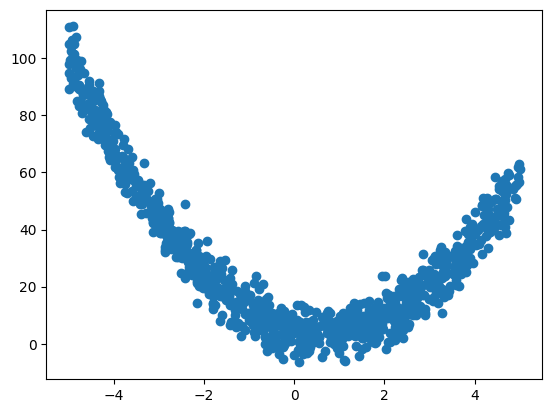

In [610]:
n = 1000
X = 10* np.random.random(n) - 5
Y = 3*X**2 - 4*X + 5 + np.random.normal(scale= 5,size = n)

plt.figure()
plt.scatter(
    X,
    Y
)


In [611]:
X[:5]

array([-3.69315088, -1.63731877, -0.50043026, -4.56399   , -4.81614041])

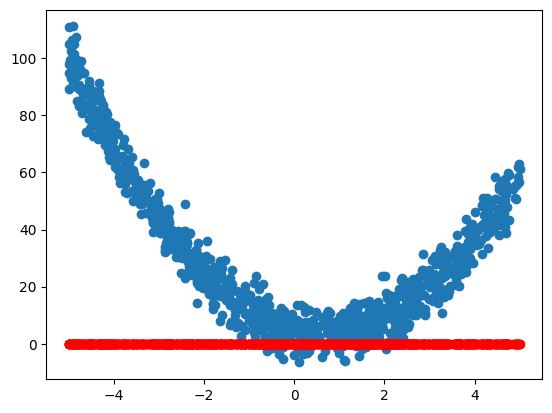

In [612]:
# Defining the expectation functions

def Q_hat_1(a,b,c , n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)**2)

def Q_hat_2(a,b,c , n=n):
    return (1/n)*sum((X + (b/(2*a) - np.sqrt(b**2 - 4*a*(c - Y))/(2*a)))**2)
  
def Q_hat_1_der_a(a,b,c, n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)*(-2*X**2))

def Q_hat_1_der_b(a,b,c, n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)*(-2*X))

def Q_hat_1_der_c(a,b,c, n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)*(-2))

def Y_args(X,a,b,c):
    return(a*X**2 + b*X + c)

plt.figure()
plt.scatter(
    X,
    Y
)

plt.scatter(X,Y_args(X,0,0,0),c = "red")

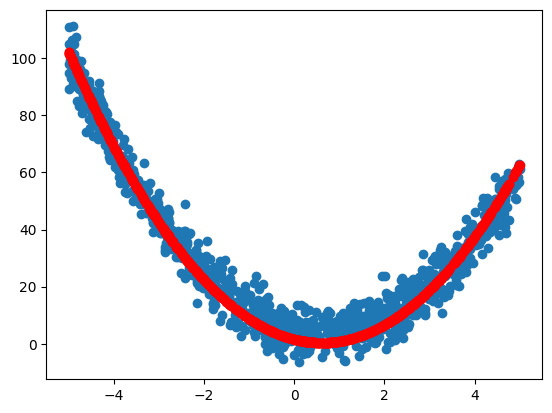

In [613]:
a,b,c = 0,0,0
lr = 0.0001
for i in range(4000):
    try:
        a = a - lr*Q_hat_1_der_a(a,b,c)
        b = b - lr*Q_hat_1_der_b(a,b,c)
        c = c - lr*Q_hat_1_der_c(a,b,c)
    except:
        print("error")
        break
    
    
plt.figure()
plt.scatter(
    X,
    Y
)

plt.scatter(X,Y_args(X,a,b,c),c = "red")

In [614]:
a,b,c

(3.2347061344747634, -3.9563455229815077, 1.573120232098032)

### Real World Data Sets

In the following part of this article, we try and apply the aforementioned method of regression on a real world dataset, "Insurance.csv". This data-set has 7 coulumns:
1. age
2. sex : catagorical {"male","female"}
3. bmi : the regressor
4. children
5. smoker : catagorical {"yes","no"}
6. region
7. charges : the target variable

We shall try to study the trends in BMI and Insurance Charges and how they vary with the given catagorical variables.

In [615]:
# Now let's try and implement the same model with a real world data set

import pandas as pd

df = pd.read_csv('Data Sets/insurance.csv')

df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Text(0.5, 1.0, 'BMI vs Insurances Charges (for male smokers)')

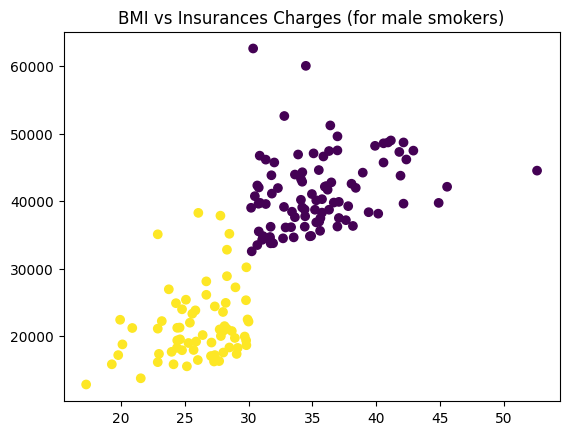

In [616]:
X = np.array(df["bmi"][df['sex'] == 'male'][df['smoker'] == 'yes'])
Y = np.array(df["charges"][df['sex'] == 'male'][df['smoker'] == 'yes'])
Z = []
for i in X:
    if i > 30:
        Z.append(0)
    else:
        Z.append(1)
        

plt.figure()
plt.scatter(X,Y, c = Z)
plt.title("BMI vs Insurances Charges (for male smokers)")

Text(0.5, 1.0, 'BMI vs Insurances Charges (for male smokers)')

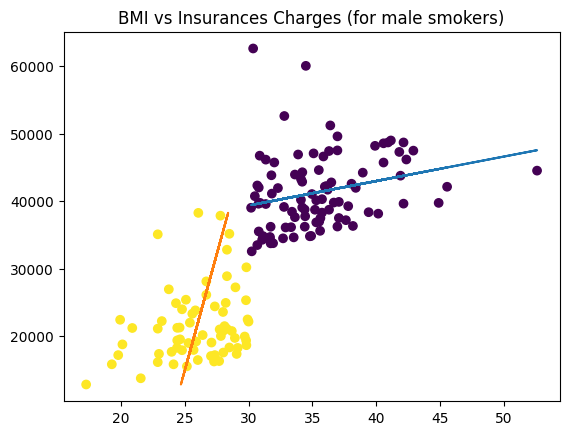

In [617]:
# Normal regression model on the two data sets 

# Spliiting the data into two factions

X_0 = []
Y_0 = []
X_1 = []
Y_1 = []

for i in range(len(X)):
    if Z[i] == 0:
        X_0.append((1,X[i]))
        Y_0.append(Y[i])
    else:
        X_1.append(X[i])
        Y_1.append((1,Y[i]))
        
X_0 = np.matrix(X_0)
Y_0 = np.matrix(Y_0)
X_1 = np.matrix(X_1)
Y_1 = np.matrix(Y_1)

beta_1 = (X_0.T*X_0).I*X_0.T*Y_0.T
beta_2 = (Y_1.T*Y_1).I*Y_1.T*X_1.T

y_pred = X_0*beta_1
x_pred = Y_1*beta_2

plt.figure()
plt.scatter(X,Y, c = Z)
plt.plot(np.array(X_0[:,1]),np.array(y_pred))
plt.plot(np.array(x_pred),np.array(Y_1[:,1]))
plt.title("BMI vs Insurances Charges (for male smokers)")

In [618]:
np.array(X_0[:,1])

array([[42.13 ],
       [35.3  ],
       [36.3  ],
       [35.6  ],
       [36.4  ],
       [36.67 ],
       [39.9  ],
       [35.2  ],
       [34.43 ],
       [36.955],
       [31.68 ],
       [37.62 ],
       [35.09 ],
       [31.35 ],
       [30.495],
       [35.53 ],
       [41.895],
       [34.8  ],
       [34.21 ],
       [31.825],
       [33.63 ],
       [31.92 ],
       [36.955],
       [42.35 ],
       [34.2  ],
       [40.565],
       [45.54 ],
       [34.39 ],
       [35.97 ],
       [30.8  ],
       [36.48 ],
       [32.3  ],
       [32.9  ],
       [40.15 ],
       [30.685],
       [33.88 ],
       [35.86 ],
       [32.775],
       [34.4  ],
       [30.25 ],
       [42.13 ],
       [40.565],
       [37.8  ],
       [34.1  ],
       [33.535],
       [38.06 ],
       [32.015],
       [31.35 ],
       [35.3  ],
       [31.13 ],
       [35.75 ],
       [31.73 ],
       [35.5  ],
       [34.105],
       [38.17 ],
       [31.79 ],
       [30.78 ],
       [38.94 ],
       [40.92 

In [619]:
# Testing the error here

sum_ = 0
for i in range(len(y_pred)):
    sum_ += (np.array(X_0[:,1])[i]-y_pred[i])**2
    
for i in range(len(x_pred)):
    sum_ += (np.array(Y_1[:,1])[i]-x_pred[i])**2
    
sum_/((len(x_pred) + len(y_pred))*(1e6)) # Scalling factor of 1e3 squared

matrix([[1197.69173132]])

### Note:

The error that we observed for fitting two different lines on the partitioned data set is:
> 1197.69173132

In [620]:
X,Y

# Since the values of Y are a bit too large, we can scale them dowm by a factor of 1k

Y = Y/1000

X[:5],Y[:5]

(array([42.13, 35.3 , 36.3 , 35.6 , 36.4 ]),
 array([39.6117577 , 36.837467  , 38.711     , 35.585576  , 51.19455914]))

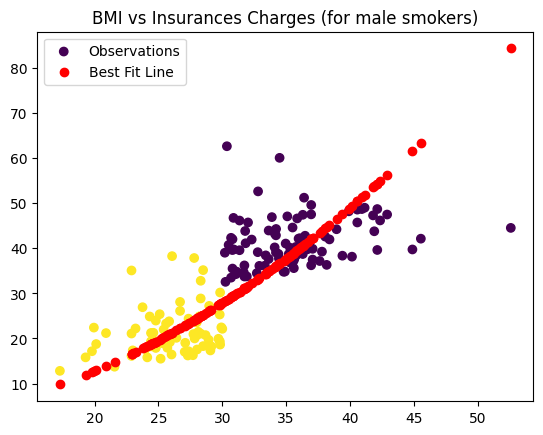

In [621]:
# Functions in question
def Q_hat_1(a,b,c , n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)**2)

def Q_hat_2(a,b,c , n=n):
    return (1/n)*sum((X + (b/(2*a) - np.sqrt(b**2 - 4*a*(c - Y))/(2*a)))**2)
  
def Q_hat_1_der_a(a,b,c, n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)*(-2*X**2))

def Q_hat_1_der_b(a,b,c, n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)*(-2*X))

def Q_hat_1_der_c(a,b,c, n=n):
    return (1/n)*sum((Y - a*X**2 - b*X - c)*(-2))

def Y_args(X,a,b,c):
    return(a*X**2 + b*X + c)

# Now we apply the swap model on the data set 
a,b,c = 1,0,1
n = len(X)
lr = 0.000001
for i in range(100):
    try:
        a = a - lr*Q_hat_1_der_a(a,b,c)
        b = b - lr*Q_hat_1_der_b(a,b,c)
        c = c - lr*Q_hat_1_der_c(a,b,c)
    except RuntimeWarning:
        print("error")
        break
    
    
plt.figure()
plt.scatter(
    X,
    Y,
    c = Z,
    label = 'Observations'
)

plt.scatter(X,Y_args(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.title("BMI vs Insurances Charges (for male smokers)")
plt.legend()

X_ms, Y_ms, Y_org_ms, Z_ms = X,Y_args(X,a,b,c), Y, Z # Storing values for later

In [622]:
a,b,c

(0.030425239214925962, -0.016442471155747658, 0.9995319550304892)

In [623]:
# Calculating the loss value again :
# Testing the error here

sum_ = 0
preds = Y_args(X,a,b,c)
for i in range(len(preds)):
    sum_ += (Y[i]-preds[i])**2
    
    
sum_/(((len(preds)))) # Scalling factor of 1e3 squared

70.14426739379736

### Note:

The error that we get for the SWAP Model for the same data set is :
> 70.14426739379736

### Observation:

This error is considerably less then compared to the error that we got using our initial 2 regression lines model. 

### Concludion:

SWAP model is better suited for this data set.

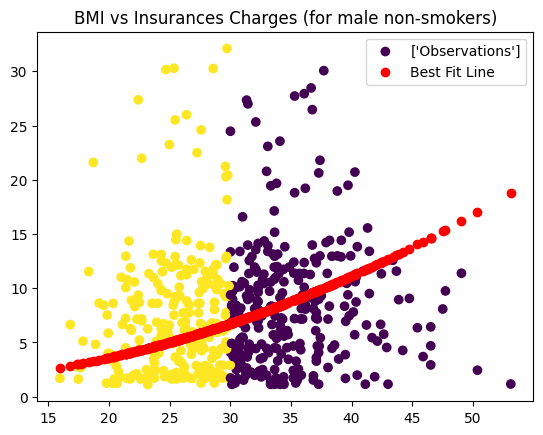

In [624]:
X = np.array(df["bmi"][df['sex'] == 'male'][df['smoker'] == 'no'])
Y = np.array(df["charges"][df['sex'] == 'male'][df['smoker'] == 'no'])
Z = []
for i in X:
    if i > 30:
        Z.append(0)
    else:
        Z.append(1)
        
Y = Y/1000

# Now we apply the swap model on the data set 
a,b,c = 1,0,1
n = len(X)
lr = 0.000001
for i in range(100):
    try:
        a = a - lr*Q_hat_1_der_a(a,b,c)
        b = b - lr*Q_hat_1_der_b(a,b,c)
        c = c - lr*Q_hat_1_der_c(a,b,c)
    except RuntimeWarning:
        print("error")
        break
    
    
plt.figure()
plt.scatter(
    X,
    Y,
    c = Z,
    label = ['Observations']
)

plt.scatter(X,Y_args(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.title("BMI vs Insurances Charges (for male non-smokers)")
plt.legend()

X_mns, Y_mns , Y_org_mns, Z_mns = X,Y_args(X,a,b,c), Y, Z # Storing values for later

In [625]:
# Calculating the loss value again :
# Testing the error here

sum_ = 0
preds = Y_args(X,a,b,c)
for i in range(len(preds)):
    sum_ += (Y[i]-preds[i])**2
    
    
sum_/(((len(preds)))) # Scalling factor of 1e3 squared

39.299922258257716

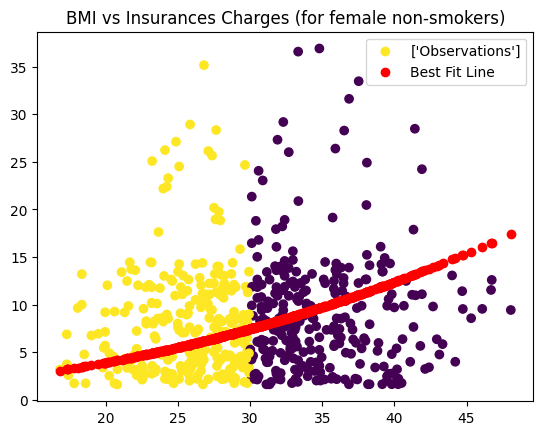

In [626]:
X = np.array(df["bmi"][df['sex'] == 'female'][df['smoker'] == 'no'])
Y = np.array(df["charges"][df['sex'] == 'female'][df['smoker'] == 'no'])
Z = []
for i in X:
    if i > 30:
        Z.append(0)
    else:
        Z.append(1)
        
Y = Y/1000

# Now we apply the swap model on the data set 
a,b,c = 1,0,1
n = len(X)
lr = 0.000001
for i in range(100):
    try:
        a = a - lr*Q_hat_1_der_a(a,b,c)
        b = b - lr*Q_hat_1_der_b(a,b,c)
        c = c - lr*Q_hat_1_der_c(a,b,c)
    except RuntimeWarning:
        print("error")
        break
    
    
plt.figure()
plt.scatter(
    X,
    Y,
    c = Z,
    label = ['Observations']
)

plt.scatter(X,Y_args(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.title("BMI vs Insurances Charges (for female non-smokers)")
plt.legend()

X_fs, Y_fs, Y_org_fs, Z_fs = X,Y_args(X,a,b,c), Y, Z # Storing values for later

In [627]:
# Calculating the loss value again :
# Testing the error here

sum_ = 0
preds = Y_args(X,a,b,c)
for i in range(len(preds)):
    sum_ += (Y[i]-preds[i])**2
    
    
sum_/(((len(preds)))) # Scalling factor of 1e3 squared

42.03273760956578

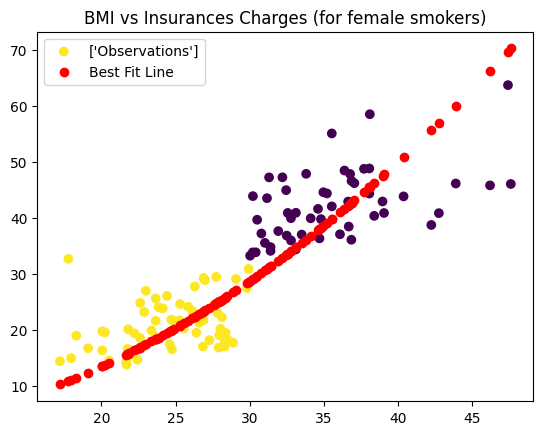

In [628]:
X = np.array(df["bmi"][df['sex'] == 'female'][df['smoker'] == 'yes'])
Y = np.array(df["charges"][df['sex'] == 'female'][df['smoker'] == 'yes'])
Z = []
for i in X:
    if i > 30:
        Z.append(0)
    else:
        Z.append(1)
        
Y = Y/1000

# Now we apply the swap model on the data set 
a,b,c = -1,0,1
n = len(X)
lr = 0.000001
for i in range(100):
    try:
        a = a - lr*Q_hat_1_der_a(a,b,c)
        b = b - lr*Q_hat_1_der_b(a,b,c)
        c = c - lr*Q_hat_1_der_c(a,b,c)
    except RuntimeWarning:
        print("error")
        break
    
    
plt.figure()
plt.scatter(
    X,
    Y,
    c = Z,
    label = ['Observations']
)

plt.scatter(X,Y_args(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.title("BMI vs Insurances Charges (for female smokers)")
plt.legend()

X_fns, Y_fns, Y_org_fns, Z_fns = X,Y_args(X,a,b,c), Y, Z # Storing values for later

In [629]:
# Calculating the loss value again :
# Testing the error here

sum_ = 0
preds = Y_args(X,a,b,c)
for i in range(len(preds)):
    sum_ += (Y[i]-preds[i])**2
    
    
sum_/(((len(preds)))) # Scalling factor of 1e3 squared

52.38889892245999

#### Final Plot

As per our goal here we can see the final plot:


Text(0.5, 1.0, 'Female Non-Smokers')

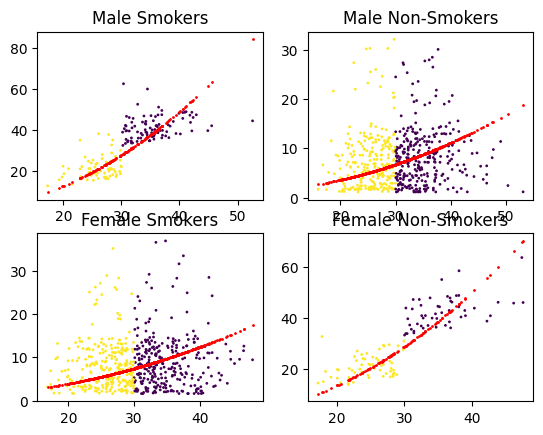

In [630]:
figrue , axis = plt.subplots(2,2)

# For Sine Function 

axis[0, 0].scatter(X_ms, Y_org_ms,c = Z_ms,s=1) 
axis[0, 0].scatter(X_ms, Y_ms,c = "red",s=1) 
axis[0, 0].set_title("Male Smokers") 
  
# For Cosine Function 
axis[0, 1].scatter(X_mns, Y_org_mns,c = Z_mns,s=1) 
axis[0, 1].scatter(X_mns, Y_mns,c = "red",s=1) 
axis[0, 1].set_title("Male Non-Smokers") 
  
# For Tangent Function 
axis[1, 0].scatter(X_fs, Y_org_fs,c = Z_fs,s=1) 
axis[1, 0].scatter(X_fs, Y_fs,c = "red",s=1) 
axis[1, 0].set_title("Female Smokers") 
  
# For Tanh Function 
axis[1, 1].scatter(X_fns, Y_org_fns,c = Z_fns,s=1) 
axis[1, 1].scatter(X_fns, Y_fns,c = "red",s=1) 
axis[1, 1].set_title("Female Non-Smokers")